In [2]:
import os
import mne
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def load_and_concat_raws(folder_path):
    raw_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.fif')]
    raws = [mne.io.read_raw_fif(f, preload=True) for f in raw_files]
    concatenated_raw = mne.concatenate_raws(raws)
    return concatenated_raw

In [3]:
raw = load_and_concat_raws("/home/grzesiek/documents/programming/projects/eeg_digit_classification/data/cyfry")

# 1. Basic Information
raw.pick_types(eeg=True)
print(raw.info)
print(raw.ch_names)
print(f"Sampling frequency: {raw.info['sfreq']} Hz")
print(f"Data duration: {raw.n_times / raw.info['sfreq']} seconds")
print(f"Number of channels: {len(raw.ch_names)}")


<Info | 10 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, T3, T4, T5, T6, F7, F8
 chs: 16 EEG
 custom_ref_applied: False
 dig: 19 items (3 Cardinal, 16 EEG)
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 meas_id: 4 items (dict)
 nchan: 16
 projs: []
 sfreq: 250.0 Hz
>
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'T3', 'T4', 'T5', 'T6', 'F7', 'F8']
Sampling frequency: 250.0 Hz
Data duration: 4954.3 seconds
Number of channels: 16


In [4]:
# 2. Plot Raw Data
raw.plot(n_channels=len(raw.ch_names), scalings='auto', title='Raw Data Plot')

qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in ""


In [5]:
raw.apply_function(fun=lambda x: x * 10**(-6))
raw.filter(l_freq=12, h_freq=35)
raw.plot(n_channels=len(raw.ch_names), scalings='auto', title='Raw Data Plot after filtering and unit conversion')

[[5000    0    7]
 [5254    0    5]
 [7259    0    1]
 [8356    0    7]
 [8609    0    2]]


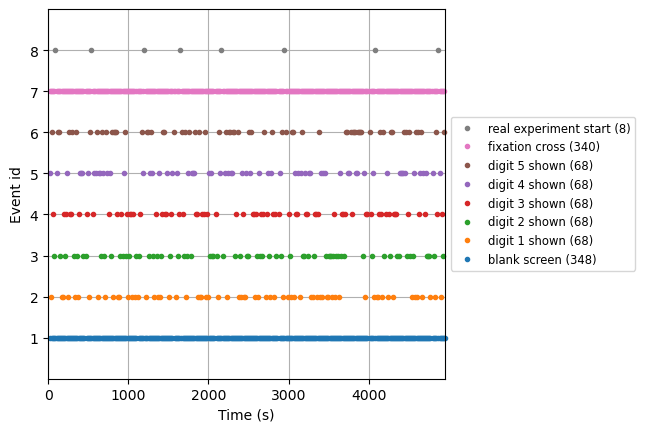

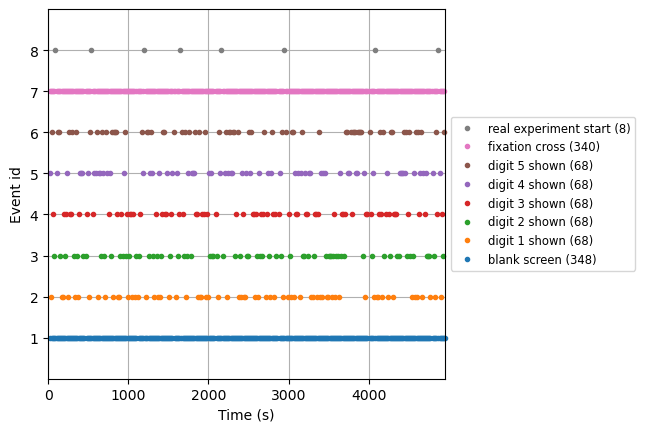

In [6]:
# 3. Event Exploration
events, event_dict = mne.events_from_annotations(raw)
print(events[:5])  # Print first 5 events
mne.viz.plot_events(events, event_id=event_dict, sfreq=raw.info['sfreq'])


/home/grzesiek/miniconda3/envs/mne/lib/python3.12/site-packages/mne/viz/utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


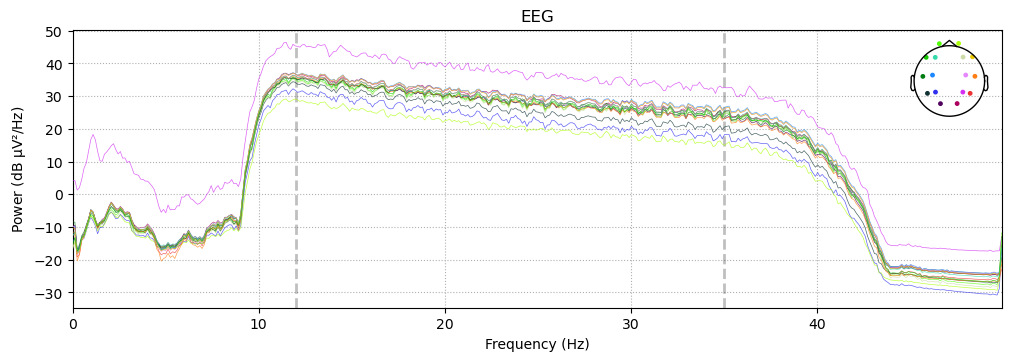

In [7]:
# 4. Channel Inspection
raw.plot_psd(fmax=50)
raw.plot(duration=5, n_channels=16)


In [8]:
# fig, ax = plt.subplots()
# psds, freqs = mne.time_frequency.psd_welch(raw, fmin=1, fmax=40, n_fft=2048)
# psds_mean = psds.mean(axis=0)
# ax.plot(freqs, psds_mean)
# ax.set_title('Power Spectral Density (PSD)')
# ax.set_xlabel('Frequency (Hz)')
# ax.set_ylabel('Power Spectral Density (dB)')

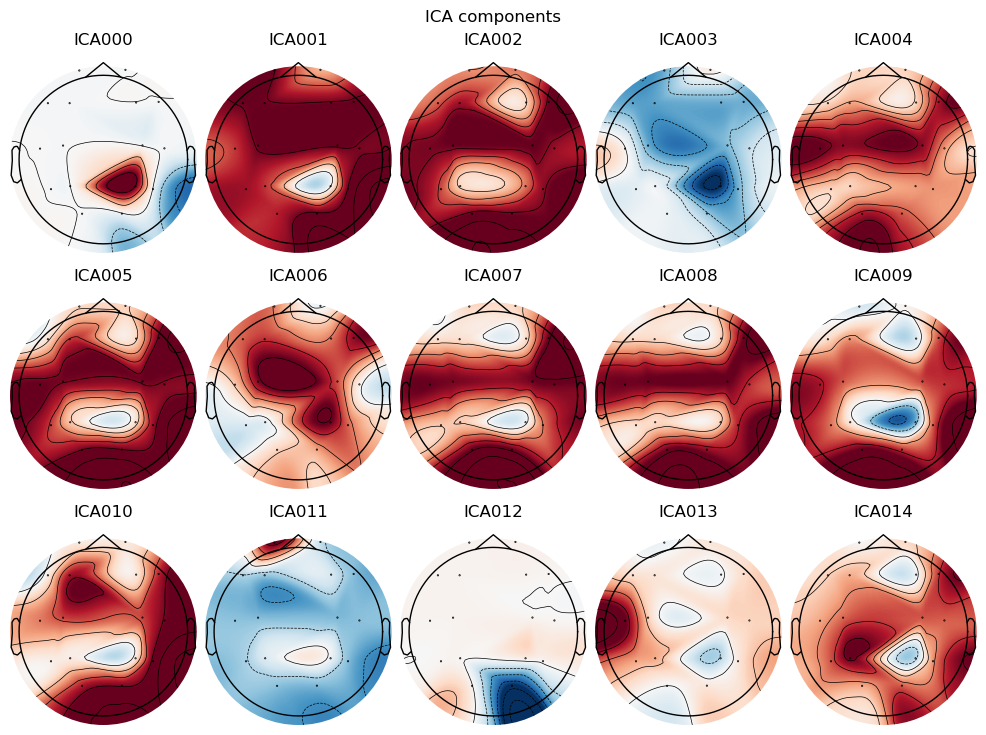

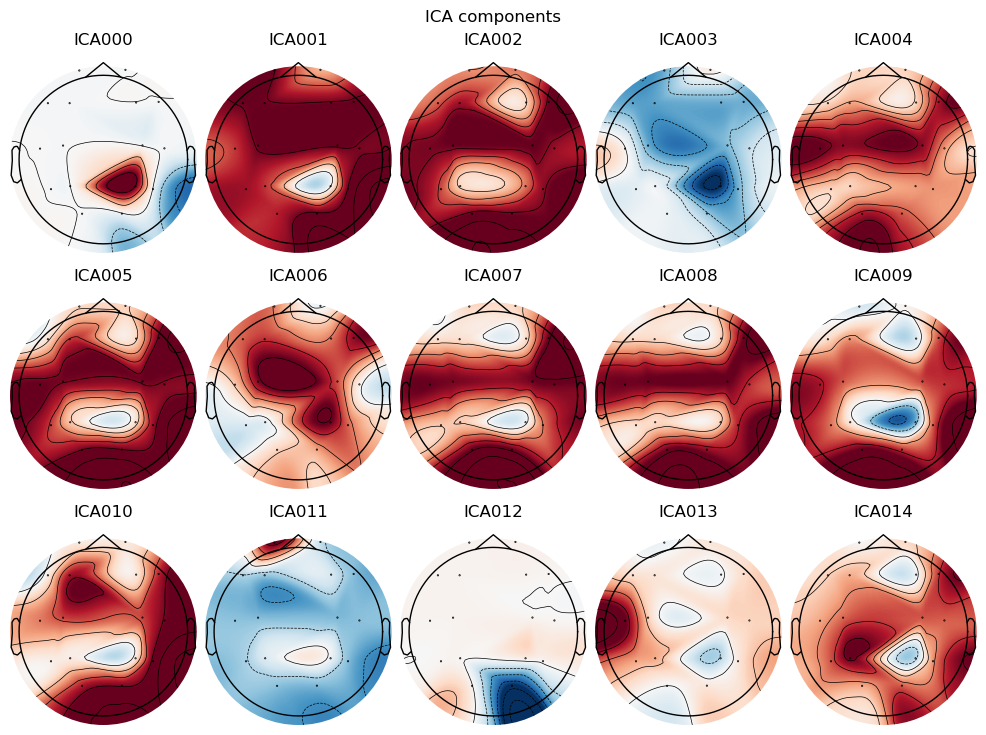

In [9]:

# 6. Artifact Detection
raw.plot(n_channels=16, butterfly=True)
ica = mne.preprocessing.ICA(n_components=15, random_state=97, max_iter='auto')
ica.fit(raw)
ica.plot_components()

In [10]:
def read_epochs_from_dir(dir_path):
    epochs = []
    for file in os.listdir(dir_path):
        if file.endswith(".fif"):
            epochs.append(mne.read_epochs(os.path.join(dir_path, file)))
    return epochs

In [11]:
epochs = read_epochs_from_dir("/home/grzesiek/documents/programming/projects/eeg_digit_classification/data/epochs")
all_epochs = mne.concatenate_epochs(epochs)
all_epochs

Number of events,340
Events,digit 1 shown: 68digit 2 shown: 68digit 3 shown: 68digit 4 shown: 68digit 5 shown: 68
Time range,-0.200 – 0.500 s
Baseline,-0.200 – 0.000 s


          event_2   event_3   event_4   event_5   event_6
Fp1      0.018820 -0.024822  0.002323 -0.002864  0.006543
Fp2      0.017364 -0.022279  0.002892 -0.003623  0.005646
F3       0.016049 -0.020011  0.003248 -0.004193  0.004906
F4       0.015497 -0.019207  0.003383 -0.004367  0.004694
C3       0.015916 -0.020161  0.003436 -0.004208  0.005017
C4       0.017049 -0.022292  0.003569 -0.003922  0.005596
P3       0.018407 -0.024719  0.003858 -0.003687  0.006141
P4       0.019601 -0.026815  0.004228 -0.003555  0.006541
O1       0.020511 -0.028323  0.004514 -0.003517  0.006814
O2       0.021218 -0.029155  0.004607 -0.003624  0.006954
T3       0.021791 -0.029279  0.004557 -0.003960  0.006891
T4       0.022139 -0.028802  0.004535 -0.004486  0.006613
T5       0.022144 -0.028118  0.004677 -0.004979  0.006276
T6       0.021866 -0.027679  0.004929 -0.005220  0.006104
F7       0.021472 -0.027441  0.005044 -0.005219  0.006145
F8       0.020985 -0.026729  0.004745 -0.005199  0.006198
event_2  1.000

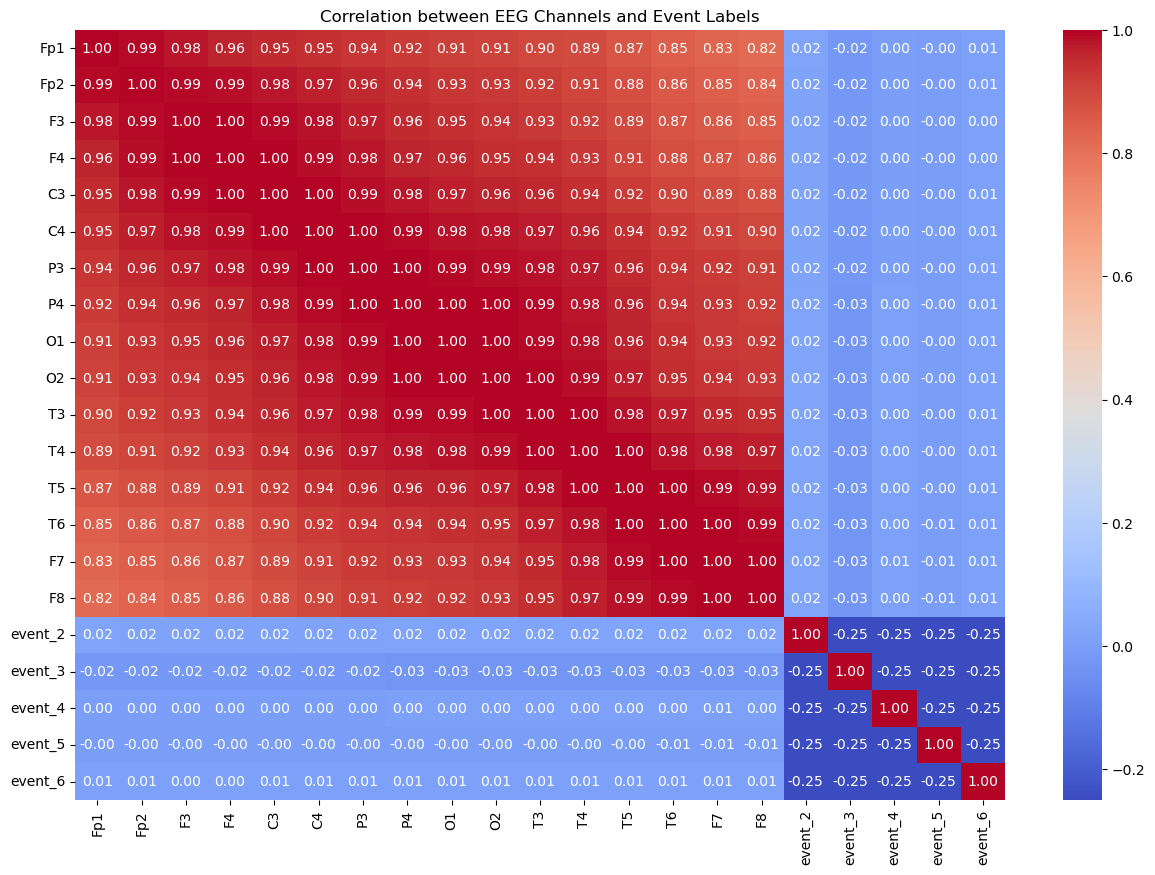

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder

data = all_epochs.get_data() 
n_epochs, n_channels, n_times = data.shape

flattened_data = data.reshape(n_epochs * n_times, n_channels)

df = pd.DataFrame(flattened_data, columns=all_epochs.ch_names)

event_labels = all_epochs.events[:, -1] 

repeated_event_labels = np.repeat(event_labels, n_times)

one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = one_hot_encoder.fit_transform(repeated_event_labels.reshape(-1, 1))

event_labels_df = pd.DataFrame(one_hot_encoded, columns=[f'event_{int(e)}' for e in one_hot_encoder.categories_[0]])

df = pd.concat([df, event_labels_df], axis=1)

correlations = df.corr(method='pearson')

print(correlations[[col for col in df.columns if col.startswith('event_')]])

plt.figure(figsize=(15, 10))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation between EEG Channels and Event Labels')
plt.show()


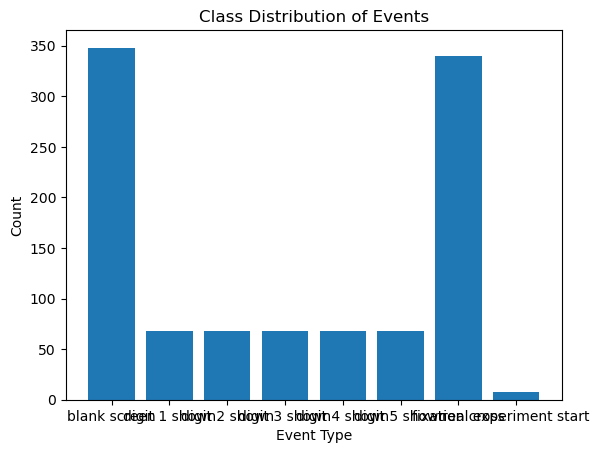

In [13]:

# 8. Class Distribution
event_counts = {key: len(events[events[:, 2] == val]) for key, val in event_dict.items()}
plt.figure()
plt.bar(event_counts.keys(), event_counts.values())
plt.xlabel('Event Type')
plt.ylabel('Count')
plt.title('Class Distribution of Events')
plt.show()


In [14]:

# 9. Data Cleaning and Preprocessing
# High-pass filter to remove slow drifts
raw.filter(l_freq=1., h_freq=None)

# Low-pass filter to remove high-frequency noise
raw.filter(l_freq=None, h_freq=40.)

# Resample the data to a lower frequency (if necessary)
raw.resample(128, npad="auto")


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,19 points
Good channels,16 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,128.00 Hz
Highpass,12.00 Hz
Lowpass,35.00 Hz


In [15]:

# 10. Extract epochs for analysis
epochs = mne.Epochs(raw, events, event_id=event_dict, tmin=-0.2, tmax=0.5, preload=True)
print(epochs)
epochs.plot(n_epochs=10, n_channels=10)

# Save cleaned data for later use
cleaned_file_path = '/path/to/cleaned_file.fif'
raw.save(cleaned_file_path, overwrite=True)

<Epochs |  524 events (all good), -0.203125 – 0.5 s, baseline -0.203125 – 0 s, ~5.8 MB, data loaded,
 'blank screen': 175
 'digit 1 shown': 34
 'digit 2 shown': 34
 'digit 3 shown': 31
 'digit 4 shown': 36
 'digit 5 shown': 37
 'fixation cross': 172
 'real experiment start': 5>


FileNotFoundError: parent directory does not exist: "/path/to"